In [1]:
"""
This script is used for training a autoencoder for gearbox fault diagnosis using TensorFlow and Keras.
It imports necessary libraries and modules for data processing, model building, training, and evaluation.
"""
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers

import load_data
import feature_process
import c_writer

# Load the GearBox data

In [2]:
PTH1 = "data/BrokenTooth"
PTH2 = "data/Healthy"
WIN_LEN = 300  # How many WIN_LEN as 1 feature point
INFERENCE_DATA_POINT = 5  # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test = load_data.create_test_train_df_from_raw(PTH1, 1, INFERENCE_DATA_POINT, WIN_LEN, (load_data.addcol_load, load_data.addcol_fault))
healthy_df_train, healthy_df_test = load_data.create_test_train_df_from_raw(PTH2, 0, INFERENCE_DATA_POINT, WIN_LEN, (load_data.addcol_load, load_data.addcol_fault))

In [3]:
broken_df_test
# broken_df_train

,a1,a2,a3,a4,load,fault
0,2.350390,1.454870,-1.667080,-2.055610,0.0,1.0
1,2.452970,1.400100,-2.825100,0.984487,0.0,1.0
2,-0.241284,-0.267390,0.793540,0.605862,0.0,1.0
3,1.130270,-0.890918,0.696969,0.613068,0.0,1.0
4,-1.296140,0.980479,-1.130560,-0.346971,0.0,1.0
...,...,...,...,...,...,...
14995,-3.443520,-0.361539,-0.376093,-2.447550,90.0,1.0
14996,2.458310,-2.838840,0.191190,-0.201169,90.0,1.0
14997,-0.755909,3.982960,-2.321580,0.749357,90.0,1.0
14998,1.299520,4.402300,-2.232460,0.535038,90.0,1.0


# Feature Process

In [4]:
# Calculate the windows size features, combine 300 data as 1 points.
Data_healthy, Lable_healthy = feature_process.window_feature_autoencoder(
    healthy_df_train, 0, WIN_LEN, 4, 16
)  # 200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.window_feature_autoencoder(broken_df_train, 1, WIN_LEN, 4, 16)
print(f"feature array shape of healthy point: {Data_healthy.shape}, {Lable_healthy.shape}")
print(f"feature array shape of broken point: {Data_broken.shape}, {Lable_broken.shape}")

feature array shape of healthy point: (3336, 16), (3336,)
feature array shape of broken point: (3301, 16), (3301,)


In [5]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy, Data_broken, Lable_healthy, Lable_broken, 0.1, 21)
print(f"train data shape: {train_data.shape}, {train_labels.shape}")
print(f"test data shape: {test_data.shape}, {test_labels.shape}")
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)

train data shape: (5973, 16), (5973,)
test data shape: (664, 16), (664,)


# Autoencoder

## Autoencoder data prepare
- Need to normalize the data
- Need to sperate the data into normal and anomalous set

In [6]:
# normalize
train_data, test_data = feature_process.normalize_data_maxmin(train_data, test_data)
print(type(train_data))

# sperate to True & False for Autoencoder
normal_train_data, anomalous_train_data = feature_process.normal_anomalous_distb(train_data, train_labels)
normal_test_data, anomalous_test_data = feature_process.normal_anomalous_distb(test_data, test_labels)
print(f"anomalous train data set: {anomalous_train_data.shape}")
print(f"normal train data set: {normal_train_data.shape}")

tf.Tensor(3158.1043774, shape=(), dtype=float64) tf.Tensor(-0.619863934954322, shape=(), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
anomalous train data set: (3012, 16)
normal train data set: (2961, 16)


## Autoencoder Training

In [14]:
def create_autoencoder(sample_shape):
    """
    Creates and compiles an autoencoder model using TensorFlow and Keras.
    Parameters:
    sample_shape (tuple): The shape of the input samples.
    Returns:
    tf.keras.Sequential: The compiled autoencoder model.
    """
    # sample_shape = normal_train_data[0].shape

    model = tf.keras.Sequential(
        [
            layers.InputLayer(input_shape=sample_shape),
            layers.Dense(8, activation="relu"),
            layers.Dense(4, activation="relu"),
            layers.Dense(4, activation="relu"),
            layers.Dense(8, activation="relu"),
            layers.Dense(*sample_shape, activation="sigmoid"),
        ]
    )

    # Display model
    model.summary()
    model.compile(optimizer="adam", loss="mae")
    return model


Autoen_model = create_autoencoder(normal_train_data[0].shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 8)                 40        
                                                                 
 dense_9 (Dense)             (None, 16)                144       
                                                                 
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train model (note Y labels are same as inputs, X)
def train_autoencoder(
    m_epochs,
    m_batch_size,
    normal_train_data_autoencoder,
    normal_test_data_autoencoder,
):
    """
    Trains an autoencoder model using the provided training and test data.
    Parameters:
    m_epochs (int): Number of epochs to train the model.
    m_batch_size (int): Batch size to use during training.
    normal_train_data_autoencoder (numpy.ndarray or tensorflow.data.Dataset)
    normal_test_data_autoencoder (numpy.ndarray or tensorflow.data.Dataset)
    Returns:
    history_ae (tensorflow.python.keras.callbacks.History)
    """
    history_ae = Autoen_model.fit(
        normal_train_data_autoencoder, normal_train_data_autoencoder, epochs=m_epochs, batch_size=m_batch_size, 
        validation_data=(normal_test_data_autoencoder, normal_test_data_autoencoder), shuffle=True
    )
    return history_ae


HISTORY = train_autoencoder(300, 128, normal_train_data, normal_test_data)

Epoch 1/300
24/24 [==============================] - 0s 6ms/step - loss: 0.4191 - val_loss: 0.4152
Epoch 2/300
24/24 [==============================] - 0s 3ms/step - loss: 0.4126 - val_loss: 0.4085
Epoch 3/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4056 - val_loss: 0.4011
Epoch 4/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3979 - val_loss: 0.3930
Epoch 5/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3894 - val_loss: 0.3839
Epoch 6/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3772 - val_loss: 0.3643
Epoch 7/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3447 - val_loss: 0.3127
Epoch 8/300
24/24 [==============================] - 0s 2ms/step - loss: 0.2743 - val_loss: 0.2236
Epoch 9/300
24/24 [==============================] - 0s 2ms/step - loss: 0.1792 - val_loss: 0.1302
Epoch 10/300
24/24 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0675
Epoch 11/

## Show the loss and decide threshold

93/93 [==============================] - 0s 773us/step


C:\Users\cychen38\AppData\Local\Temp\ipykernel_50104\1733330225.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  axes_sub = sns.lineplot(data=history_autoen.history["loss"], ci=None, label="Training Loss", ax=ax[0])
C:\Users\cychen38\AppData\Local\Temp\ipykernel_50104\1733330225.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  axes_sub = sns.lineplot(data=history_autoen.history["val_loss"], ci=None, label="Validation Loss", ax=ax[0])


95/95 [==============================] - 0s 892us/step


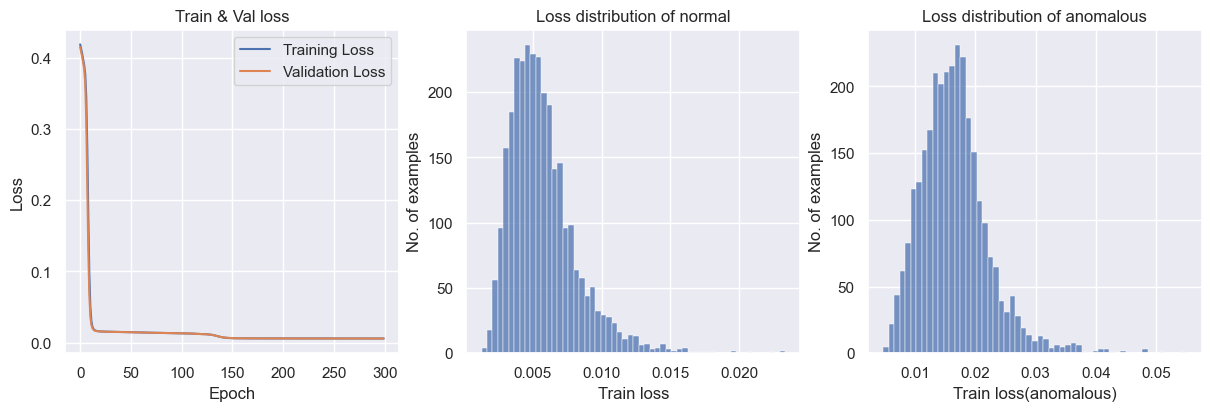

Threshold:  0.010711372829973698


In [16]:
def result_autoencoder(model_autoen, history_autoen, normal_data, anomalous_data):
    """
    Visualizes the training and validation loss, and the loss distributions for normal and anomalous data.
    Also calculates and returns the threshold for fault detection based on the model error.
    Parameters:
    model_autoen (tf.keras.Model): The trained autoencoder model.
    history_autoen (tf.keras.callbacks.History): The history object containing training and validation loss.
    normal_data (np.ndarray): The normal data used for training the autoencoder.
    anomalous_data (np.ndarray): The anomalous data used for testing the autoencoder.
    Returns:
    float: The calculated threshold for fault detection.
    """

    sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, ticks
    _, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))

    axes_sub = sns.lineplot(data=history_autoen.history["loss"], ci=None, label="Training Loss", ax=ax[0])
    axes_sub = sns.lineplot(data=history_autoen.history["val_loss"], ci=None, label="Validation Loss", ax=ax[0])
    axes_sub.set_xlabel("Epoch")
    axes_sub.set_ylabel("Loss")
    axes_sub.set_title("Train & Val loss")

    # For finding threshold to fault detection, histogram, of train loss and test loss was plotted
    reconstructions = model_autoen.predict(normal_data)
    train_loss = tf.keras.losses.mae(reconstructions, normal_data)
    train_loss = np.array(train_loss)  # convert to np.array
    axes_sub = sns.histplot(data=train_loss, ax=ax[1])
    axes_sub.set_xlabel("Train loss")
    axes_sub.set_ylabel("No. of examples")
    axes_sub.set_title("Loss distribution of normal")

    reconstructions = model_autoen.predict(anomalous_data)
    test_loss = tf.keras.losses.mae(reconstructions, anomalous_data)
    # test_loss = tf.keras.losses.mse(reconstructions, anomalous_data)
    test_loss = np.array(test_loss)  # convert to np.array
    axes_sub = sns.histplot(data=test_loss, ax=ax[2])
    axes_sub.set_xlabel("Train loss(anomalous)")
    axes_sub.set_ylabel("No. of examples")
    axes_sub.set_title("Loss distribution of anomalous")

    plt.show()

    # threshold for fault detection based on model error
    th = np.mean(train_loss) + 2 * np.std(train_loss)
    print("Threshold: ", th)
    return th


threshold = result_autoencoder(Autoen_model, HISTORY, normal_train_data, anomalous_train_data)

## Test Result

In [17]:
def predict(model, data2predict, th):
    """
    Predicts whether the reconstruction loss of the data is below a given threshold.
    """
    reconstructions = model(data2predict)
    return tf.math.less(tf.keras.losses.mae(reconstructions, data2predict), th)


def print_stats(predictions, labels):
    """
    Prints the accuracy, precision, and recall of the given predictions compared to the true labels.
    Parameters:
    predictions (array-like): The predicted labels.
    labels (array-like): The true labels.
    Returns:
    None
    """
    print(f"Accuracy = {accuracy_score(labels, predictions)}")
    print(f"Precision = {precision_score(labels, predictions)}")
    print(f"Recall = {recall_score(labels, predictions)}")


# accuracy
print(f"Test Data number: {test_data.shape[0]}")
preds = predict(Autoen_model, test_data, threshold)
print_stats(preds, test_labels)

print(f"Train Data number: {train_data.shape[0]}")
preds = predict(Autoen_model, train_data, threshold)
print_stats(preds, train_labels)

# accuracy for

Test Data number: 664
Accuracy = 0.9186746987951807
Precision = 0.8864864864864865
Recall = 0.9647058823529412
Train Data number: 5973
Accuracy = 0.9104302695462917
Precision = 0.8746139592340951
Recall = 0.9564336372847011


## Show MCU Inference Result first
- This dataset is for MCU inference latter, and we use PC python to inference first.
- The `Accuracy` value should be almost same as MCU result latter.  

In [18]:
# accuracy for MCU inference data
# calculate feature
Data_healthy_test, Lable_healthy_test = feature_process.window_feature_autoencoder(
    healthy_df_test, 0, WIN_LEN, 4, 16
)  # 200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken_test, Lable_broken_test = feature_process.window_feature_autoencoder(broken_df_test, 1, WIN_LEN, 4, 16)
print(f"feature array shape of test healthy point: {Data_healthy_test.shape}, {Lable_healthy_test.shape}")
print(f"feature array shape of test broken point: {Data_broken_test.shape}, {Lable_broken_test.shape}")
inference_data = np.concatenate([Data_healthy_test, Data_broken_test], axis=0)
inference_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis=0)

# normalize
print(max_val, min_val)
inference_data = (inference_data - min_val) / (max_val - min_val)
inference_data = tf.cast(inference_data, tf.float32)

print(f"Test Data number: {inference_data.shape[0]}")
preds = predict(Autoen_model, inference_data, threshold)
print_stats(preds, inference_label)

feature array shape of test healthy point: (50, 16), (50,)
feature array shape of test broken point: (50, 16), (50,)
tf.Tensor(3158.1043774, shape=(), dtype=float64) tf.Tensor(-0.619863934954322, shape=(), dtype=float64)
Test Data number: 100
Accuracy = 0.92
Precision = 0.8888888888888888
Recall = 0.96


# TensorFlow Lite Conversion

### 1. Save as saved_model

In [19]:
# If we're happy with the performance, save the model
ori_model = Autoen_model
KERAS_MODEL_NAME = "autoencoder"

tf.saved_model.save(ori_model, KERAS_MODEL_NAME)

INFO:tensorflow:Assets written to: autoencoder\assets


### 2. Save as TFLite

In [20]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()
open(os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + ".tflite")), "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmp58td97vk\assets


4400

### 3. Convert TFLite to C++ file

In [23]:
def tflite_to_tflu(*, models_path, c_model_name, keras_model_name, th, max_v, min_v):
    """
    Converts a TensorFlow Lite model to a TensorFlow Lite Micro model and saves it as a C source file.
    Returns:
        None
    """
    tflite_name = os.path.join(keras_model_name, (keras_model_name + ".tflite"))
    my_f_name = os.path.join(models_path, c_model_name) + ".cc"
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $WIN_LEN --max_val_train $max_v --min_val_train $min_v --threshold_val $th


MODELS_PATH = "model"
C_MODEL_NAME = r"Gearbox_fault_" + KERAS_MODEL_NAME
tflite_to_tflu(models_path=MODELS_PATH, c_model_name=C_MODEL_NAME, keras_model_name=KERAS_MODEL_NAME, th=threshold, max_v=max_val.numpy(), min_v=min_val.numpy())

# Convert to int8 TFLite and testing
- Int8 full quantization 

### 1. Save as Int8 TFLite

In [24]:
# Convert the model to the TensorFlow Lite format with quantization
NUM_REP_DATA_SAMPLES = 300


def _rep_dataset():
    """Generator function to produce representative dataset."""
    for idx in range(len(normal_train_data)):
        if idx >= NUM_REP_DATA_SAMPLES:
            break
        yield [tf.dtypes.cast(train_data[idx], tf.float32)]


converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
converter.representative_dataset = _rep_dataset
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()
open(os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + "_int8quantized.tflite")), "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmpmoitwb22\assets


INFO:tensorflow:Assets written to: C:\Users\cychen38\AppData\Local\Temp\tmpmoitwb22\assets
c:\ProgramData\miniforge3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


3984

### 2. Test the Int8 TFLite 

In [25]:
def tflite_inference(input_data, inf_tflite_path):
    """Call forwards pass of TFLite file and returns the result.

    Args:
        input_data: Input data to use on forward pass.
        inf_tflite_path: Path to TFLite file to run.

    Returns:
        Output from inference.
    """
    interpreter = tf.lite.Interpreter(model_path=inf_tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_dtype = input_details[0]["dtype"]
    output_dtype = output_details[0]["dtype"]

    # Check if the input/output type is quantized,
    # set scale and zero-point accordingly
    if input_dtype == np.int8:
        input_scale, input_zero_point = input_details[0]["quantization"]
    else:
        input_scale, input_zero_point = 1, 0

    input_data = input_data / input_scale + input_zero_point
    input_data = np.round(input_data) if input_dtype == np.int8 else input_data

    if output_dtype == np.int8:
        output_scale, output_zero_point = output_details[0]["quantization"]
    else:
        output_scale, output_zero_point = 1, 0

    interpreter.set_tensor(input_details[0]["index"], tf.cast(input_data, input_dtype))
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]["index"])

    output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)

    return output_data

In [26]:
tflite_path = os.path.join(KERAS_MODEL_NAME, (KERAS_MODEL_NAME + "_int8quantized.tflite"))

predicted_indices = []
for data, label in zip(test_data, test_labels):  # pylint: disable=unused-variable
    prediction = tflite_inference(tf.expand_dims(data, axis=0), tflite_path)
    predicted_indices.append(prediction)
predicted_indices = tf.convert_to_tensor(np.vstack(predicted_indices), dtype=tf.float32)

In [27]:
loss = tf.keras.losses.mae(predicted_indices, test_data)
preds = tf.math.less(loss, threshold)
print_stats(preds, test_labels)

Accuracy = 0.9141566265060241
Precision = 0.8834688346883469
Recall = 0.9588235294117647


### 3. Convert TFLite to C++ file

In [28]:
MODELS_PATH = "model"
C_MODEL_NAME = r"Gearbox_fault_" + KERAS_MODEL_NAME + r"_int8quantized"
tflite_to_tflu(models_path=MODELS_PATH, c_model_name=C_MODEL_NAME, keras_model_name=KERAS_MODEL_NAME, th=threshold, max_v=max_val.numpy(), min_v=min_val.numpy())

# Convert the test data to C code
- This data set is after preprocessed.
- Just used to make sure the model is ok.

In [29]:
how_many_test = test_data.shape[0]

Xtest = test_data.numpy()[:how_many_test, :]  # transfer to nparray

Xtest_str = c_writer.create_array(Xtest, "float", "X_test")

ytest = test_labels[:how_many_test].astype(int)
ytest_str = c_writer.create_array(ytest, "uint8_t", "y_test")

test_d = Xtest_str + ytest_str

header_test_d = c_writer.create_header(test_d, "gearbox_test_data")
with open(os.path.join("data", "gearbox_test_data") + ".h", "w", encoding="utf-8") as file:
    file.write(header_test_d)

# Convert the raw data to C code
- This data is raw data, for edge device to inference.
- It is a more realistic case.

In [30]:
def save_test_data_in_c(data_x, label_y):
    """
    Saves test data and labels into a C header file.
    This function takes test data and labels, converts them into C arrays,
    and writes them into a header file named 'gearbox_raw_test_data.h' in the 'data' directory.
    Args:
        data_x (numpy.ndarray): The test data to be saved.
        label_y (numpy.ndarray): The labels corresponding to the test data.
    Returns:
        None
    """

    xtest_str = c_writer.create_array(data_x, "float", "X_test", 1)

    test_label_data = label_y.astype(int)
    test_label_data_str = c_writer.create_array(test_label_data, "uint8_t", "y_test")

    test_str = xtest_str + test_label_data_str

    header_test_writed = c_writer.create_header(test_str, "gearbox_raw_test_data")
    with open(os.path.join("data", "gearbox_raw_test_data") + ".h", "w", encoding="utf-8") as f:
        f.write(header_test_writed)


raw_data = np.concatenate([healthy_df_test, broken_df_test], axis=0)
raw_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis=0)
print(f"The raw data size is: {len(raw_data)}")
print(f"The raw label size is: {len(raw_label)}")
save_test_data_in_c(raw_data[:, 0:4], raw_label)

The raw data size is: 30000
The raw label size is: 100
